In [4]:
import sys
sys.path.append("../")
import time
from lib.header_script import *
import lib.Common as Common
import torch
from tqdm import tqdm
from pykeops.torch import LazyTensor
# from LogSinkhornGPU import LogSinkhornCudaImage, AbstractSinkhorn
import LogSinkhornGPU
from LogSinkhornGPU import UnbalancedSinkhornCudaImageOffset, KL

import os
import psutil
import time

import numpy as np
import pickle
import matplotlib.pyplot as plt

from lib.header_params import *
from lib.AuxConv import *

device = "cuda"
# torch_dtype = torch.float32
torch_dtype = torch.float64


torch_options = dict(dtype=torch_dtype, device=device)
torch_options_int = dict(dtype=torch.int32, device=device)

    
# Input data files
params["setup_fn1"] = "../examples/data/f-000-256.pickle"
params["setup_fn2"] = "../examples/data/f-001-256.pickle"
params["setup_dumpfile_finest_pre"] = "experiments/" + \
    params["setup_tag"]+"_dump_finest_pre.dat"
params["setup_dumpfile_finest"] = "experiments/" + \
    params["setup_tag"]+"_dump_finest.dat"

# load input measures from file
# do some preprocessing and setup multiscale representation of them
muX, posX, shapeX = Common.importMeasure(params["setup_fn1"])
muY, posY, shapeY = Common.importMeasure(params["setup_fn2"])
N = shapeX[0]
print(f"N = {N}")
print(torch_dtype)


# Get multiscale torch hierarchy
muXL = torch.tensor(muX, **torch_options).view(shapeX)
muYL = torch.tensor(muY, **torch_options).view(shapeX)
shapeXL = shapeX
shapeYL = shapeY

N = 256
torch.float64


In [ ]:
results = dict()

In [14]:
dx = 1.0
#reach_list = [1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 10000]
# reach_list = [1/4, 1/2, 1, 2, 4, 8, 16, 64, 10000]
reach_list = [1/4, 1/2, 2, 8]
#reach_list = [1000.0]
#blur_list = [0.5, 1.0, 2.0, 4.0]
#reach_list = [16.0]
blur_list = [8.0]

sinkhorn_inner_iter = 10

print("reach, blur")
for reach in reach_list:
    sinkhorn_max_iter = 1000 if reach < 1 else 10000
    for blur in blur_list:
        eps = blur**2
        times = np.arange(0, sinkhorn_max_iter, sinkhorn_inner_iter)
        ntimes = len(times)
        score_keys = ["primal_score", "dual_score", "margX_error", "pd_gap" , "pd_gap_rel", "pd_gap_improved", 
                      "pd_gap_improved_rel", "margX_error_KL", "transport_score", "marginal_score",
                     "alphaPXpi", "KL PXpi", "KL* alpha"]
        results_instance = dict(times = times, primal_score = np.zeros(ntimes))
        for k in score_keys:
            results_instance[k] = np.zeros(ntimes)
        
        lam = (reach*N)**2
        x = torch.arange(shapeXL[0], **torch_options) * dx
        x = x.reshape(1, -1)
        alpha = torch.zeros(shapeXL, **torch_options)
        
        solver = UnbalancedSinkhornCudaImageOffset(muXL.view(1, *shapeXL), 
            muYL.view(1, *shapeYL), ((x, x), (x, x)), eps, lam,
            alpha_init = alpha.view(1, *shapeXL), 
            inner_iter = sinkhorn_inner_iter,
            max_iter = params["sinkhorn_max_iter"],
            max_error = params["sinkhorn_error"],
            max_error_rel = params["sinkhorn_error_rel"])
        
        print(reach, blur)
        for i in tqdm(range(ntimes)):
            results_instance["margX_error"][i] = solver.iterate(sinkhorn_inner_iter)
            # New primal candidate
            PXpi = solver.get_actual_X_marginal()
            PYpi = solver.get_actual_Y_marginal()
            new_alpha = solver.get_new_alpha()
            #results_instance["margX_error_KL"][i] = KL(PXpi, solver.mu)
            results_instance["transport_score"][i] = torch.sum(solver.alpha * solver.mu + solver.beta * solver.nu).item()
            results_instance["marginal_score"][i] = + lam*KL(PXpi, solver.mu) + lam*KL(PYpi, solver.nu)
            p = solver.primal_score()
            d = solver.dual_score()
            results_instance["primal_score"][i] = p
            results_instance["dual_score"][i] = d
            results_instance["pd_gap"][i] = p - d
            results_instance["pd_gap_rel"][i] = (p - d)/d
            pd_gap_improved = improved_PD_gap(solver.alpha, PXpi, solver.mu, lam, eps, N)
            results_instance["pd_gap_improved"][i] = pd_gap_improved.item()
            results_instance["pd_gap_improved_rel"][i] = results_instance["pd_gap_improved"][i] / d
            # KL stopping criterion
            #PXpi_ideal = torch.exp(-solver.alpha / solver.lam) * solver.mu
            #results_instance["margX_error_KL"][i] = LogSinkhornGPU.KL(PXpi_ideal, PXpi)
            results_instance["margX_error_KL"][i] = KL(PXpi, torch.exp(-solver.alpha / solver.lam)*solver.mu)
            results_instance["alphaPXpi"][i] = torch.sum(solver.alpha * PXpi)
            results_instance["KL PXpi"][i] = lam*KL(PXpi, solver.mu)
            results_instance["KL* alpha"][i] = -lam*torch.sum((torch.exp(-solver.alpha / lam) -1)* solver.mu)
            
            

        results[(reach, blur)] =  results_instance


reach, blur
0.25 8.0
100%|██████████| 100/100 [00:27<00:00,  3.61it/s]
0.5 8.0
100%|██████████| 100/100 [00:27<00:00,  3.59it/s]
2 8.0
100%|██████████| 1000/1000 [03:38<00:00,  4.57it/s]
8 8.0
100%|██████████| 1000/1000 [02:37<00:00,  6.35it/s]


# Visualize results

<ipython-input-22-47d644106bc1>:75: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(list(map(ff, reach_list_expand[::2])))


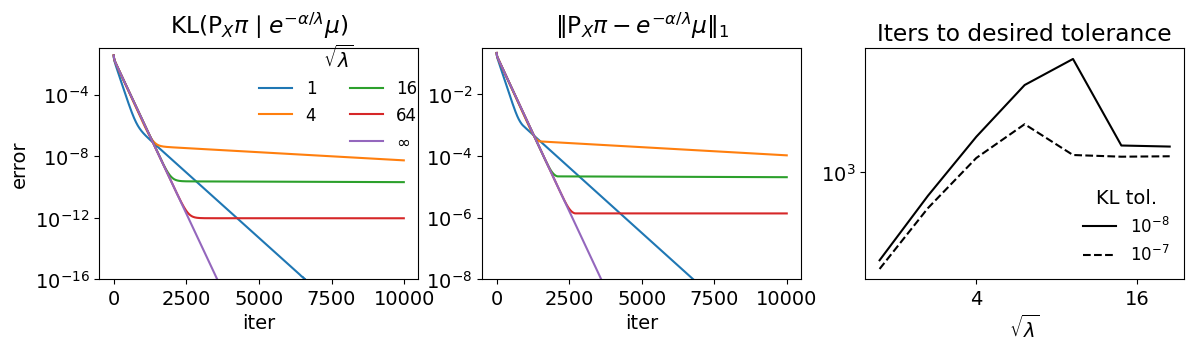

In [22]:
plt.rcParams.update({
    "text.usetex": False,
    "font.size" : 14})


def ff(x):
    """
    format fraction
    """
    if x < 1:
        invx = 1/x
        if abs(invx - int(invx)) < 1e-8:
            invx = int(invx)
        return f"1/{invx}"
    else:
        if abs(x - int(x)) < 1e-8:
            x = int(x)
        return f"{x}"
    
# %%
colors = ["tab:"+c for c in ["blue", "orange", "green", "red", "purple", "brown", "pink"]]



reach_list = [1, 4, 16, 64, 10000]
# reach_list = [1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0]

# %%

fig, axs = plt.subplots(1,3,figsize = (14, 3))
# fig, axs = plt.subplots(1,2,figsize = (10, 4))
blur = 8.0
# Last plot
reach_list_expand = [1/4, 1/2, 1.0, 2.0, 4.0, 8.0, 16.0]
tols = [1e-8, 1e-7]
for i, reach in enumerate(reach_list):
    r = results[(reach, blur)]
    reach_str = ff(reach) if reach < 100 else r"$\infty$" 
    Niters = len(r["margX_error_KL"])
    axs[0].plot(10*np.arange(0,Niters), r["margX_error_KL"],
                 c = colors[i % len(colors)], label = reach_str)
    axs[1].plot(10*np.arange(0,Niters), r["margX_error"], 
                c = colors[i%len(colors)], label = reach_str)
    if i == 1: 
        axs[0].plot([],[], c = "w", label = " ")
axs[0].set_xlabel("iter")
axs[1].set_xlabel("iter")
axs[0].set_ylabel("error")
axs[0].set_ylim([1e-16, 1e-1])
axs[1].set_ylim([1e-8, 0.3])
axs[0].semilogy()
axs[1].semilogy()
# axs[0].axhline(tols[0], color = "k", linestyle = "--")
axs[0].set_title(r"${\rm KL}({\rm P}_X \pi \mid e^{-\alpha/\lambda}\mu)$", y = 1.03)
axs[1].set_title(r"$\|{\rm P}_X \pi - e^{-\alpha/\lambda}\mu\|_1$",y = 1.03)
axs[0].legend(title = r"$\sqrt{\lambda}$", ncol = 2, frameon = False, fontsize = 12, loc = (0.48, 0.53))

linestyles = ["-", "--"]
for (k, tol) in enumerate(tols): 
    Niter_list = np.zeros(len(reach_list_expand))
    for (i, reach) in enumerate(reach_list_expand):
        r = results[(reach, blur)]
        Niter_list[i] = np.sum(r["margX_error_KL"] > tol) * 10
    axs[2].plot(reach_list_expand, Niter_list, color = "k", ls = linestyles[k], 
                label = r"$10^{" + str(int(np.log10(tol))) + "}$")
        
axs[2].set_xscale("log")
axs[2].set_yscale("log")
#axs[2].set_xticks(reach_list_expand, mayor = True)
#yticks = [200, 400, 1000, 2000, 4000]
#axs[2].set_yticks(yticks, mayor = True)
#axs[2].set_yticklabels(yticks)
axs[2].set_yticks([], minor = True)
axs[2].set_xticks([], minor = True)
axs[2].set_xticklabels(list(map(ff, reach_list_expand[::2])))
axs[2].set_xlabel(r"$\sqrt{\lambda}$")
axs[2].set_title("Iters to desired tolerance")
axs[2].legend(title = "KL tol.", frameon = False, fontsize = 12, loc = "lower right")

plt.show()